## gac params

b: bucket size (limits scope of the GAC clustering)
p: reduction factor (i.e 100 clusters becomes 50 clusters)
s: min similarity threshold (for two clusters to be combined)
t: number of terms to keep per cluster prototype
term weighting: how to vectorize (i.e "ltc", from SMART weighting scheme)
re: # of iterations between re-clustering 

Input: Sorted stories + Params
Output: Forest of binary tree clusters

### basic gac - greedy, bottom-up

n_clus_init = parition size


repeat until most similar < s or n_clus > n_clus_init/p
    - linkage
    - clusters
    - average centroids and timestamps

### temporal gac

- sort stories
- let sort be initial partition
- repeat until most similar < s or n_clus < b 
    - re-bucketing
    - `if i % k == 0 && i != 0`
        - apply gac to all clusters
    - else
        - divide partition into 'b' buckets (non-overlapping and consecutive)
        - apply gac to each bucket
        - remove bucket boundaries
    



In [1]:
import json
import operator
import itertools
import pandas as pd
import scipy as sp
import numpy as np
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
%matplotlib inline
#cophenet test
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [42]:
#library functions
def reduce_and_plot_clusters(X, model, title=""):
    X_reduced = TruncatedSVD().fit_transform(X)
    X_embedded = TSNE(learning_rate=100).fit_transform(X_reduced)

    n_clus = len(set(model.labels_.tolist()))

    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x",
                c=model.labels_.tolist(), cmap=plt.cm.get_cmap("jet", n_clus))
    plt.colorbar(ticks=range(n_clus))
    plt.clim(-0.5, (n_clus - 0.5))
    plt.savefig('i/reduce_and_plot_clusters' +
                str(datetime.now()) + '.png')
    plt.show()

    
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
#             x = i
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
            
    plt.show()
    
    return ddata

## Read Data

In [105]:
# file_num = [35,30]
file_num = [35,30,1,5]
# file_num = [35]

data = []
for f in file_num: 
    print f
    with open("../datasets/raw-data/"+str(f)+".json", 'rb') as infile:
        data.extend(json.load(infile))
        
print len(data)

35
30
1
5
583


# pre-process (entities)

In [44]:
# stories = [doc["_source"]["content"] for doc in data]
# times = [doc]
# ids = [doc["_id"] for doc in data]

def format_entities(norm_ent):
    ents = []
    for ent in norm_ent:
        try:
            ents.append(ent['surface-form'])
        except:
            continue
    return " ".join(ents)

d = [{"id": doc["_id"],
  "first-published": doc["_source"]["first-published"],
  "title": doc["_source"]["title"],
  "summary": doc["_source"]["title"],
  "content": doc["_source"]["content"],
  "entities": format_entities(doc["_source"]["normalised-entities"])} for doc in data]

df_story = pd.DataFrame(d)

df_story['first-published-epoch'] = df_story['first-published'].apply(lambda x : int(datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").strftime("%s")))
df_story = df_story.sort_values(by='first-published-epoch')
df_story = df_story.reset_index(drop=True)

In [45]:
vect = TfidfVectorizer(use_idf=True, norm='l2', sublinear_tf=True)
vsm = vect.fit_transform(df_story["content"].values)

# original
vsm_arr = vsm.toarray()
# vsm_arr = vsm.todense()

df_story['vsm'] = [r for r in vsm_arr]

# def gac

In [46]:
df_story.head()

,content,entities,first-published,id,summary,title,first-published-epoch,vsm
0,Partners Group anticipates secondaries pricing...,Partners Group,2015-08-31T00:00:00Z,225f3ef1-88be-41b4-8aab-3e12b42aef83,"Partners Group cautious on PE, overweight RE i...","Partners Group cautious on PE, overweight RE i...",1440975600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Partners Group has been investing in real esta...,Partners Group Zug Norway,2015-08-31T00:00:00Z,2e021cc0-8589-4e33-9ec9-357f0ab3e099,Partners: Non-traditional RE secondary deals o...,Partners: Non-traditional RE secondary deals o...,1440975600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Sep 01, 2015( Jewish Business News: http://jew...",Johnston Press Deal Israeli 02 Portsmouth YouT...,2015-09-01T00:00:00Z,78196621-1340-43ab-9ee2-61864cb10e70,UK Publisher Johnston Press Launches Exclusive...,UK Publisher Johnston Press Launches Exclusive...,1441062000,"[0.0, 0.0, 0.0, 0.0561453845455, 0.0, 0.078605..."
3,World News: 08:00 GMT Tuesday 1st September 20...,Johnston Press Deal Thomson Reuters Portsmouth...,2015-09-01T07:00:43Z,9d633317-7716-448e-bf4b-9a8eff6642ff,Leading UK Publisher Johnston Press Launches E...,Leading UK Publisher Johnston Press Launches E...,1441087243,"[0.0539190712885, 0.0, 0.0, 0.048687886212, 0...."
4,Johnston Press has agreed a multi-year partner...,Johnston Press,2015-09-01T09:36:36Z,916f3424-854a-4f88-a72e-ccbcd77d6b06,Johnston Press agrees multi-year content deal ...,Johnston Press agrees multi-year content deal ...,1441096596,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## GAC (with stopping critera)

In [62]:
# util

# GAC Model
def mycosine(x1, x2):
    x1 = x1.reshape(1,-1)
    x2 = x2.reshape(1,-1)
    ans = 1 - cosine_similarity(x1, x2)
    return max(ans[0][0], 0)

def get_linkage_matrix(vsm):
    Z = linkage(vsm, method='average', metric=mycosine)
    c, coph_dists = cophenet(Z, pdist(vsm))
    print "cophenet test: ", c
    return Z

def get_cluster_size(vsm, Z, p, s):
    n = vsm.shape[0]
    for i, z in enumerate(Z):
        #         print i, z
        if z[2] > (1-s):
            # print i, ": Min similarity reached"
            # print Z[i]
            max_d = Z[i][2]
            n_clus = n - i
            break
        if n * p == i:
            # print i, ": Max reduction reached"
            # print Z[i]
            max_d = Z[i][2]
            n_clus = n - i
            break

    return [n_clus, max_d]
            
    print "n_clus", n_clus
            
    return n_clus

def get_clusters(Z, n_clus, criterion='maxclust'):
    clusters = fcluster(Z, n_clus, criterion='maxclust')

In [48]:
# tunable params

b = (400 / 15836) * df_story.shape[0]
p = 0.5
s = 0.2
t = 100
# term weighting = "ltc" # possible through sklearn
re = 5

In [71]:
# reconsturct vsm: reconstruct np.ndarray from pd.Series
def recon_vsm(vsm_series):
    rows = vsm_series.shape[0]
    cols = vsm_series.iloc[0].shape[0]
    print "[EDEN I/O -- recon_vsm] (rows,cols): ", rows, cols
    vsm = np.zeros((rows, cols))

    for i, r in enumerate(vsm_series):
        vsm[i] = r

    # print "[EDEN I/O -- recon_vsm] vsm shape: ", vsm.shape
    # print "[EDEN I/O -- recon_vsm] vsm type: ", type(vsm)
    # print "[EDEN I/O -- recon_vsm] vsm[0] type: ", type(vsm[0])

    return vsm

# creation dictionary and lists of ordering of clustering
# from linkage matrix
# anatomy of z: z[0] - first doc, z[1] - second doc
# returns dict: key - doc, value - order
def get_cluster_order(Z):
    cluster_order_dict = {}
    cluster_order_list = []
    for i, z in enumerate(Z):
        # create pairs based on order
        print 2*i, z[0]
        print 2*i+1, z[1]
        cluster_order_dict[z[0]] = 2 * i
        cluster_order_dict[z[1]] = 2 * i + 1
        # add docs to list
        cluster_order_list.extend([z[0], z[1]])
    
    return [cluster_order_dict, cluster_order_list]

# build centroid
def build_centroids(group, cluster_order_dict):
    print group['cluster'].value_counts()
    idx = group.index.values
    print "idx", idx
    print "cluster_order_dict", cluster_order_dict
    
    # print "name: ", group.name, "group len: ", len(group), "IDX: ", idx
    # if not singleton (incrementally average vectors and timestamps)
    if len(group) == 1:
        return group
    else:
        # get idx, order and associated (id, time, vsm vectors)
        order = [cluster_order_dict[i] for i in idx] 
        idx_order = sorted(zip(idx, order), key=lambda x: x[1])
        idx_order = [list(el) for el in idx_order]
        id_vector = [group.loc[i[0]]['id'] for i in idx_order]
        time_vector = [group.loc[i[0]]['first-published-epoch'] for i in idx_order]
        vsm_vector = [group.loc[i[0]]['vsm'] for i in idx_order]
    
        # debug
        # print "BEFORE PROCESSING"
        # print "idx_order: ", idx_order
        # print "id_vector: ", id_vector
        # print "time_vector: ", time_vector
        # print "vsm_vector: ", vsm_vector
        
        # pair immediate pairs i, j, where j = i+1
        # and update vectors
        for i, el in enumerate(idx_order):
            if i + 1 < len(idx_order):
                j = i + 1
                if idx_order[i][1] == idx_order[j][1] - 1:
#                     print "pair found: ", idx_order[i][0], idx_order[j][0]
                    # update idx_order
                    idx_order[i][0] = [idx_order[i][0], idx_order[j][0]]
                    idx_order[i][1] = np.mean([idx_order[i][1], idx_order[j][1]])
                    idx_order.pop(j)
                    # update id_vector
#                     id_vector[i] = [id_vector[i], id_vector[j]]
#                     id_vector.pop(j)
                    # update time_vector
                    time_vector[i] = np.mean([time_vector[i], time_vector[j]])
                    time_vector.pop(j)
                    # update vsm_vector
                    vsm_vector[i] = np.mean(np.array([vsm_vector[i], vsm_vector[j]]), axis=0)
                    vsm_vector.pop(j)
             
        i = 0
        j = 1
        # Merge remaining clusters in order
        # and update vectors
        while len(idx_order) > 1:
#             print "merge pair: ", idx_order[i][0], idx_order[j][0]
            # update idx_order
            idx_order[i][0] = [idx_order[i][0], idx_order[j][0]]
            idx_order[i][1] = np.mean([idx_order[i][1], idx_order[j][1]])
            idx_order.pop(j)
            # update id_vector
#             id_vector[i] = [id_vector[i], id_vector[j]]
            # update time_vector
            time_vector[i] = np.mean([time_vector[i], time_vector[j]])
            time_vector.pop(j)

            vsm_vector[i] = np.mean(np.array([vsm_vector[i], vsm_vector[j]]), axis=0)
            vsm_vector.pop(j)    
                    
        # perform remaining averageing
                    
        # print "AFTER PROCESSING"
        # print "id_vector: ", id_vector
        # print "idx_order: ", idx_order
        # print "time_vector: ", time_vector
        # print "vsm_vector: ", vsm_vector
        
        group_columns = group.columns
        df_group = pd.DataFrame(columns = group_columns)
        
        group_data = []
        for col in group_columns:
            if col == 'id':
                group_data.append(id_vector)
            elif col == 'first-published-epoch':
                group_data.append(time_vector[0])
            elif col == 'vsm':
                group_data.append(vsm_vector[0])
            elif col == 'cluster':
                group_data.append(group.name)
            else:
                group_data.append(list(group[col]))
        
        df_group.loc[0] = group_data
        print "success"
        return df_group

In [50]:
Z = get_linkage_matrix(recon_vsm(df_story['vsm']))
n_clus = get_cluster_size(vsm, Z)
clusters = fcluster(Z, n_clus, criterion='maxclust')
df_story['cluster'] = clusters
[cluster_order_dict, cluster_order_list] = get_cluster_order(Z)
print len(df_story)
df_update = df_story.groupby('cluster').apply(build_centroids).reset_index(drop=True)
print len(df_update)

[EDEN I/O -- recon_vsm] (rows,cols):  58 2784
cophenet test:  0.938680052662
29 : Max reduction reached
Z values
[ 27.       28.        0.61896   2.     ]
n_clus 29
0 18.0
1 19.0
2 40.0
3 43.0
4 45.0
5 46.0
6 53.0
7 54.0
8 31.0
9 39.0
10 25.0
11 60.0
12 26.0
13 41.0
14 32.0
15 63.0
16 3.0
17 6.0
18 62.0
19 65.0
20 35.0
21 37.0
22 2.0
23 66.0
24 4.0
25 16.0
26 33.0
27 64.0
28 36.0
29 38.0
30 69.0
31 70.0
32 29.0
33 67.0
34 34.0
35 71.0
36 68.0
37 72.0
38 5.0
39 73.0
40 24.0
41 75.0
42 23.0
43 78.0
44 48.0
45 49.0
46 8.0
47 9.0
48 20.0
49 61.0
50 42.0
51 52.0
52 21.0
53 82.0
54 74.0
55 79.0
56 27.0
57 28.0
58 0.0
59 1.0
60 59.0
61 84.0
62 22.0
63 76.0
64 85.0
65 86.0
66 12.0
67 44.0
68 47.0
69 50.0
70 15.0
71 88.0
72 13.0
73 87.0
74 56.0
75 57.0
76 11.0
77 55.0
78 51.0
79 90.0
80 10.0
81 17.0
82 80.0
83 93.0
84 77.0
85 99.0
86 94.0
87 96.0
88 91.0
89 98.0
90 30.0
91 97.0
92 89.0
93 101.0
94 58.0
95 92.0
96 95.0
97 100.0
98 102.0
99 105.0
100 103.0
101 106.0
102 104.0
103 107.0
104 7.0
10

In [51]:
df_update

,content,entities,first-published,id,summary,title,first-published-epoch,vsm,cluster
0,"[AP3, Sweden's third national pension fund, ha...",[Sweden Eskilstuna Halmstad Karlskrona Swedish...,"[2015-09-02T00:00:00Z, 2015-09-02T00:00:00Z]","[ccaf4766-12ce-401e-aae2-1c1d2b81b82b, 4a23c92...","[AP3 enters office, retail property joint vent...","[AP3 enters office, retail property joint vent...",1.441148e+09,"[0.0, 0.0, 0.0359290905178, 0.0, 0.0, 0.0, 0.0...",1
1,The Swiss private markets investment manager h...,Partners Group Nordic Swiss,2015-09-02T00:00:00Z,94a8cbfa-cd77-4654-a701-8412d7598551,Partners Group buys Nordic real estate portfolio,Partners Group buys Nordic real estate portfolio,1.441148e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
2,[Partners Group has bought three stakes in a t...,[Partners Group Finnish UK Industri Kapital No...,"[2015-10-06T00:00:00Z, 2015-10-21T00:00:00Z]","[e0639ade-a8ea-4f6e-8f6c-e7571e941506, 82a2e56...","[Partners buys tail-end IK buyout stakes, Part...","[Partners buys tail-end IK buyout stakes, Part...",1.444734e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.030...",3
3,"[portfo... [[ Press release Baar-Zug, Swi...",[Partners Group Switzerland DLJ New York Tenne...,"[2015-10-01T00:00:00Z, 2015-10-01T00:00:00Z, 2...","[4a494e65-4a7c-4ca7-a068-8e27ecfecc29, 3b4d2d3...",[newsbox: Partners Group completes tail-end se...,[newsbox: Partners Group completes tail-end se...,1.443666e+09,"[0.0312606605131, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",4
4,Partners Group has closed on the acquisition o...,DLJ Partners Group Zug New York Tennessee Cali...,2015-09-30T00:00:00Z,f0a866ba-0244-4a72-95af-8a0ba1a174b2,Partners restructures DLJ fund - exclusive,Partners restructures DLJ fund - exclusive,1.443568e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
5,Partners Group anticipates secondaries pricing...,Partners Group,2015-08-31T00:00:00Z,225f3ef1-88be-41b4-8aab-3e12b42aef83,"Partners Group cautious on PE, overweight RE i...","Partners Group cautious on PE, overweight RE i...",1.440976e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
6,Partners Group has been investing in real esta...,Partners Group Zug Norway,2015-08-31T00:00:00Z,2e021cc0-8589-4e33-9ec9-357f0ab3e099,Partners: Non-traditional RE secondary deals o...,Partners: Non-traditional RE secondary deals o...,1.440976e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
7,The market for real estate secondaries investm...,Partners Group India,2015-09-10T00:00:00Z,7fc01584-5679-4cfd-9d8a-76f96e0ba984,Asian RE secondaries deal volume to pick up,Asian RE secondaries deal volume to pick up,1.441840e+09,"[0.0, 0.0, 0.0, 0.0630569788831, 0.0, 0.0, 0.0...",8
8,A host of pure-play and multi-strategy manager...,Hong Kong China India Japan Merrill Lynch Harb...,2015-09-08T16:39:00Z,8909a76f-4c19-4b3d-b58a-9e6db917ce40,Asia secondaries: Worth the wait?,Asia secondaries: Worth the wait?,1.441727e+09,"[0.0, 0.0481055108076, 0.0, 0.0, 0.0, 0.0, 0.0...",9
9,A boom from Japanese institutional investors b...,Japanese Mark Evans Africa London Paris Milan ...,2015-10-27T00:00:00Z,5e073c47-ec91-496e-acc5-7228b9cde371,Japanese pensions to invest in RE secondaries,Japanese pensions to invest in RE secondaries,1.445904e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10


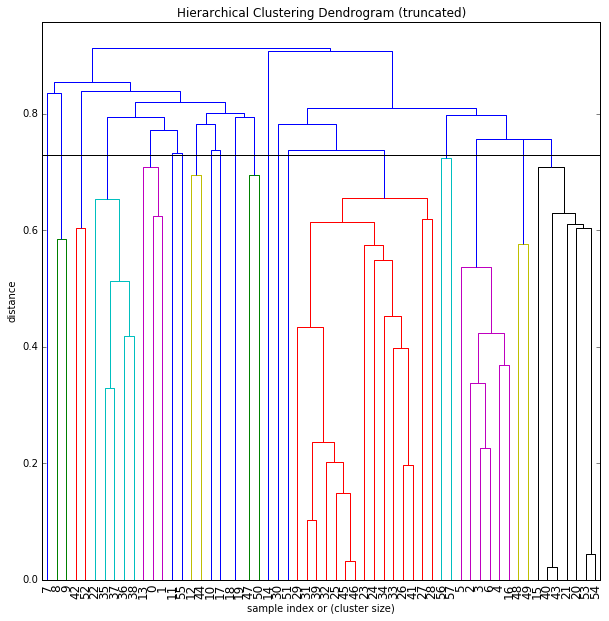

In [52]:
plt.figure(figsize=(10,10))

ddata = fancy_dendrogram(
    Z,
#     labels = df_story.index,
    truncate_mode='lastp',
    p=58,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d = 0.7284 # useful in small plots so annotations don't overlap
)

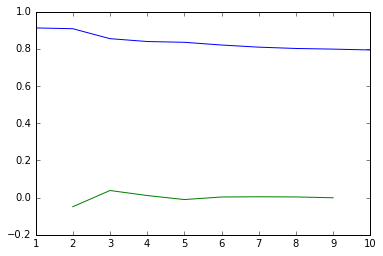

clusters: 3


In [53]:

last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k

In [ ]:
class new_model:
    def __init__(self, labels_):
        self.labels_ = labels_
    
reduce_and_plot_clusters(vsm, new_model(clusters))

In [ ]:
Z[:12]

In [27]:
df_update

,content,entities,first-published,id,summary,title,first-published-epoch,vsm,cluster
0,[Partners Group has bought three stakes in a t...,[Partners Group Finnish UK Industri Kapital No...,"[2015-10-06T00:00:00Z, 2015-10-21T00:00:00Z]","[[e0639ade-a8ea-4f6e-8f6c-e7571e941506, 82a2e5...","[Partners buys tail-end IK buyout stakes, Part...","[Partners buys tail-end IK buyout stakes, Part...",1.444734e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0385246302765, 0.0...",1
1,[Real estate secondaries funds are chasing abo...,"[Landmark Partners Partners Group DLJ, Harbour...","[2015-10-12T00:00:00Z, 2015-10-19T00:00:00Z]","[[ce14a151-39a1-4ec0-bb50-039be6b883fc, c02fac...","[Real estate secondaries funds target $2.34bn,...","[Real estate secondaries funds target $2.34bn,...",1.444907e+09,"[0.0, 0.0, 0.0, 0.0749754211087, 0.0, 0.0, 0.0...",2
2,[KKR & Co. is aiming to raise at least $1.5 bi...,[KKR Henry Kravis George Roberts Americas TPG ...,"[2015-09-20T00:00:00Z, 2015-09-21T20:43:21Z]","[[87e2f9b4-d94d-4aee-9f11-edccf38dae0c, ef9ca5...",[KKR said to seek over $1.5 billion for second...,[KKR said to seek over $1.5 billion for second...,1.442784e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,[Rising prices in the European infrastructure ...,"[Pantheon London Partners Group, Pantheon Pant...","[2015-09-09T00:00:00Z, 2015-10-08T00:00:00Z]","[[f45fa173-cfb3-4cd7-b8cf-9f4470130b23, d37b0f...",[Pricing for European infra secondaries to sta...,[Pricing for European infra secondaries to sta...,1.443006e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02809132...",4
4,The story was updated with spokeswoman's comme...,Partners Group Pennsylvania UK Australia,2015-09-08T00:00:00Z,e21d4298-ba54-4f9f-ae99-045561d56e99,Partners holds first close on 6th secondaries ...,Partners holds first close on 6th secondaries ...,1.441667e+09,"[0.0, 0.0, 0.0, 0.0, 0.0828000280252, 0.0, 0.0...",5
5,Private equity investors are increasingly worr...,HarbourVest Partners AlpInvest Partners Partne...,2015-09-18T00:00:00Z,93557c34-49fe-46a7-9d9b-567f1f99ad0f,Currency volatility a concern for secondaries ...,Currency volatility a concern for secondaries ...,1.442531e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042...",6
6,"[AP3, Sweden's third national pension fund, ha...",[Sweden Eskilstuna Halmstad Karlskrona Swedish...,"[2015-09-02T00:00:00Z, 2015-09-02T00:00:00Z]","[[ccaf4766-12ce-401e-aae2-1c1d2b81b82b, 4a23c9...","[AP3 enters office, retail property joint vent...","[AP3 enters office, retail property joint vent...",1.441148e+09,"[0.0, 0.0, 0.0350046760653, 0.0, 0.0, 0.0, 0.0...",7
7,[Partners Group has closed on the acquisition ...,[DLJ Partners Group Zug New York Tennessee Cal...,"[2015-09-30T00:00:00Z, 2015-10-01T00:00:00Z, 2...","[[[[u'4a494e65-4a7c-4ca7-a068-8e27ecfecc29', u...","[Partners restructures DLJ fund - exclusive, P...","[Partners restructures DLJ fund - exclusive, P...",1.443617e+09,"[0.0173105877105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",8
8,[Partners Group has been investing in real est...,"[Partners Group Zug Norway, Partners Group, Pa...","[2015-08-31T00:00:00Z, 2015-08-31T00:00:00Z, 2...","[[[2e021cc0-8589-4e33-9ec9-357f0ab3e099, 225f3...",[Partners: Non-traditional RE secondary deals ...,[Partners: Non-traditional RE secondary deals ...,1.441408e+09,"[0.0, 0.0, 0.0, 0.0355797316026, 0.0, 0.0, 0.0...",9
9,A host of pure-play and multi-strategy manager...,Hong Kong China India Japan Merrill Lynch Harb...,2015-09-08T16:39:00Z,8909a76f-4c19-4b3d-b58a-9e6db917ce40,Asia secondaries: Worth the wait?,Asia secondaries: Worth the wait?,1.441727e+09,"[0.0, 0.0510020241453, 0.0, 0.0, 0.0, 0.0, 0.0...",10


In [32]:
for i in df_story['id']:
    print type(i)

<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>


In [33]:
for i in df_update['id']:
    print type(i)

<type 'list'>
<type 'list'>
<type 'list'>
<type 'list'>
<type 'unicode'>
<type 'unicode'>
<type 'list'>
<type 'list'>
<type 'list'>
<type 'unicode'>
<type 'unicode'>
<type 'unicode'>


In [34]:
df_story[df_story['id'] == u'94a8cbfa-cd77-4654-a701-8412d7598551']

,content,entities,first-published,id,summary,title,first-published-epoch,vsm,cluster
4,The Swiss private markets investment manager h...,Partners Group Nordic Swiss,2015-09-02T00:00:00Z,94a8cbfa-cd77-4654-a701-8412d7598551,Partners Group buys Nordic real estate portfolio,Partners Group buys Nordic real estate portfolio,1441148400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12


In [41]:
id_cluster = {}
for i, row in df_update.iterrows():
            if isinstance(row['id'], list):
                print "yes"
                for id_ in row['id']:
                    id_cluster[id_] = row['cluster']
            else:
                print "no"
                id_cluster[row['id']] = row['cluster']

yes
yes
yes
yes
no
no
yes
yes
yes
no
no
no


In [40]:
id_cluster

{u'225f3ef1-88be-41b4-8aab-3e12b42aef83': 9.0,
 u'2e021cc0-8589-4e33-9ec9-357f0ab3e099': 9.0,
 u'3b4d2d37-83f2-4055-9343-dde8a4134ca1': 8.0,
 u'4a23c921-c6a7-4bde-9ea9-c260542cb71e': 7.0,
 u'4a494e65-4a7c-4ca7-a068-8e27ecfecc29': 8.0,
 u'7fc01584-5679-4cfd-9d8a-76f96e0ba984': 12.0,
 u'82a2e56a-39ba-41ca-b87f-fdd583827704': 1.0,
 u'87e2f9b4-d94d-4aee-9f11-edccf38dae0c': 3.0,
 u'88b1f076-8195-41a8-9a86-585e17d903dc': 8.0,
 u'c02fac78-8c29-4dd0-a151-9d780408e4a1': 2.0,
 u'ccaf4766-12ce-401e-aae2-1c1d2b81b82b': 7.0,
 u'ce14a151-39a1-4ec0-bb50-039be6b883fc': 2.0,
 u'd37b0f3e-8a37-4a96-b0a2-2fa51bdf19fb': 6.0,
 u'dc681378-2149-4fee-a71f-3b91e203e4c9': 8.0,
 u'e0639ade-a8ea-4f6e-8f6c-e7571e941506': 1.0,
 u'ef9ca591-19d5-4e12-bae6-a460b67aeeb2': 3.0,
 u'f0a866ba-0244-4a72-95af-8a0ba1a174b2': 8.0,
 u'f45fa173-cfb3-4cd7-b8cf-9f4470130b23': 4.0}

In [38]:
clusters = [id_cluster[id_] for id_ in df_story['id'].values]

KeyError: u'94a8cbfa-cd77-4654-a701-8412d7598551'

In [97]:
df_story
df_story = df_story.drop('cluster', 1)

In [98]:
df_split = np.array_split(df_story, 5)

In [100]:
df_ = df_split[1]
df_

,content,entities,first-published,id,summary,title,first-published-epoch,vsm
12,Rising prices in the European infrastructure s...,Pantheon London Partners Group,2015-09-09T00:00:00Z,f45fa173-cfb3-4cd7-b8cf-9f4470130b23,Pricing for European infra secondaries to stab...,Pricing for European infra secondaries to stab...,1441753200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,The market for real estate secondaries investm...,Partners Group India,2015-09-10T00:00:00Z,7fc01584-5679-4cfd-9d8a-76f96e0ba984,Asian RE secondaries deal volume to pick up,Asian RE secondaries deal volume to pick up,1441839600,"[0.0, 0.0, 0.0, 0.0630569788831, 0.0, 0.0, 0.0..."
14,LikeTweet+1PinShare Earning money online is no...,YouTube Vimeo Dailymotion Nirajan Nepali Kathm...,2015-09-11T16:31:41Z,21ab5e4f-e407-4ac8-92ed-5d2c037b0e7f,Vidinterest Publisher is Taboola for Videos Only,Vidinterest Publisher is Taboola for Videos Only,1441985501,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,"\nLONDON and COLOGNE, Germany, Sept. 14, 2...",Showcase Cologne Germany The Weather Channel P...,2015-09-14T07:01:04Z,8dc4d4b8-0a11-4b3a-97ee-665f8ec5a6f0,Media Advisory -- Taboola to Showcase Discover...,Media Advisory -- Taboola to Showcase Discover...,1442210464,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.070..."
16,Local and regional news publisher Johnston Pre...,Johnston Press Portsmouth,2015-09-15T11:45:57Z,671b3909-18ac-4b5a-89f0-a29e7fce46cd,Regional publisher Johnston Press announces Ta...,Regional publisher Johnston Press announces Ta...,1442313957,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,Private equity investors are increasingly worr...,HarbourVest Partners AlpInvest Partners Partne...,2015-09-18T00:00:00Z,93557c34-49fe-46a7-9d9b-567f1f99ad0f,Currency volatility a concern for secondaries ...,Currency volatility a concern for secondaries ...,1442530800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,KKR & Co. is aiming to raise at least $1.5 bil...,KKR Henry Kravis George Roberts Americas TPG B...,2015-09-20T00:00:00Z,87e2f9b4-d94d-4aee-9f11-edccf38dae0c,KKR said to seek over $1.5 billion for second ...,KKR said to seek over $1.5 billion for second ...,1442703600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,KKR & Co. is aiming to raise at least $1.5 bil...,KKR Henry Kravis George Roberts Americas TPG B...,2015-09-21T20:43:21Z,ef9ca591-19d5-4e12-bae6-a460b67aeeb2,KKR said to seek over $1.5 billion for second ...,KKR said to seek over $1.5 billion for second ...,1442864601,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20,"NEW YORK, Sept. 22, 2015 (GLOBE NEWSWIRE) --...",Dan Abrams Adam The Weather Channel Pasadena L...,2015-09-22T14:37:37Z,f06d3549-6a8f-4673-9606-5518c38e9e0e,Taboola Signs 3-Year Deal With Abrams Media to...,Taboola Signs 3-Year Deal With Abrams Media to...,1442929057,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21,"BANGKOK, Thailand and SYDNEY, Australia, Sept....",Australia BANGKOK Thailand SYDNEY Australian A...,2015-09-29T22:04:07Z,54643410-99c2-45d3-b972-7b4798942c6e,Business Insider Australia Launches Taboola Ac...,Business Insider Australia Launches Taboola Ac...,1443560647,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [103]:
def basic_GAC(df_story, p, s):
    df_story = df_story.reset_index(drop=True)
    print "BASIC GAC"
    vsm = recon_vsm(vsm_series=df_story['vsm'])
    Z = get_linkage_matrix(vsm)
    print Z
    [n_clus, max_d] = get_cluster_size(vsm, Z, p=p, s=s)
    print n_clus
    clusters = fcluster(Z, n_clus, criterion='maxclust')
    print "clusters", clusters
    df_story['cluster'] = clusters
    [cluster_order_dict, cluster_order_list] = get_cluster_order(Z)
    print "cluster_order_list", cluster_order_list
    # print len(df_story)
    df_update = df_story.groupby('cluster').apply(lambda group: build_centroids(group, cluster_order_dict)).reset_index(drop=True)
    # print len(df_update)
    # optional : fancy dendrogram
    # ddata = fancy_dendrogram(
    #     Z,
    #     truncate_mode='lastp',
    #     p=58,
    #     leaf_rotation=90.,
    #     leaf_font_size=12.,
    #     show_contracted=True,
    #     annotate_above=10,
    #     max_d=max_d  # useful in small plots so annotations don't overlap
    # )

    return df_update

In [104]:
basic_GAC(df_, 0.5, 0.2)

BASIC GAC
[EDEN I/O -- recon_vsm] (rows,cols):  12 2784
cophenet test:  0.967191768256
[[  6.        7.        0.        2.     ]
 [  8.        9.        0.61088   2.     ]
 [  3.       13.        0.69746   3.     ]
 [  0.       10.        0.73382   2.     ]
 [  1.       15.        0.77155   3.     ]
 [  4.       14.        0.79003   4.     ]
 [ 12.       16.        0.80621   5.     ]
 [  5.       18.        0.82802   6.     ]
 [ 11.       17.        0.8534    5.     ]
 [  2.       20.        0.90108   6.     ]
 [ 19.       21.        0.914    12.     ]]
6
clusters [2 2 6 4 4 3 1 1 4 4 2 5]
0 6.0
1 7.0
2 8.0
3 9.0
4 3.0
5 13.0
6 0.0
7 10.0
8 1.0
9 15.0
10 4.0
11 14.0
12 12.0
13 16.0
14 5.0
15 18.0
16 11.0
17 17.0
18 2.0
19 20.0
20 19.0
21 21.0
cluster_order_list [6.0, 7.0, 8.0, 9.0, 3.0, 13.0, 0.0, 10.0, 1.0, 15.0, 4.0, 14.0, 12.0, 16.0, 5.0, 18.0, 11.0, 17.0, 2.0, 20.0, 19.0, 21.0]
1    2
Name: cluster, dtype: int64
idx [6 7]
cluster_order_dict {0.0: 6, 1.0: 8, 2.0: 18, 3.0: 4, 4.0: 1

,content,entities,first-published,id,summary,title,first-published-epoch,vsm,cluster
0,[KKR & Co. is aiming to raise at least $1.5 bi...,[KKR Henry Kravis George Roberts Americas TPG ...,"[2015-09-20T00:00:00Z, 2015-09-21T20:43:21Z]","[87e2f9b4-d94d-4aee-9f11-edccf38dae0c, ef9ca59...",[KKR said to seek over $1.5 billion for second...,[KKR said to seek over $1.5 billion for second...,1.442784e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,[Rising prices in the European infrastructure ...,"[Pantheon London Partners Group, Partners Grou...","[2015-09-09T00:00:00Z, 2015-09-10T00:00:00Z, 2...","[f45fa173-cfb3-4cd7-b8cf-9f4470130b23, f0a866b...",[Pricing for European infra secondaries to sta...,[Pricing for European infra secondaries to sta...,1.442250e+09,"[0.0, 0.0, 0.0, 0.0315284894416, 0.0, 0.0, 0.0...",2
2,Private equity investors are increasingly worr...,HarbourVest Partners AlpInvest Partners Partne...,2015-09-18T00:00:00Z,93557c34-49fe-46a7-9d9b-567f1f99ad0f,Currency volatility a concern for secondaries ...,Currency volatility a concern for secondaries ...,1.442531e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,"[ \nLONDON and COLOGNE, Germany, Sept. 14, ...",[Showcase Cologne Germany The Weather Channel ...,"[2015-09-14T07:01:04Z, 2015-09-15T11:45:57Z, 2...","[f06d3549-6a8f-4673-9606-5518c38e9e0e, 5464341...",[Media Advisory -- Taboola to Showcase Discove...,[Media Advisory -- Taboola to Showcase Discove...,1.442521e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017...",4
4,"India, Sept. 30 -- New Delhi Television announ...",New Delhi Television India NDTV,2015-09-30T00:00:00Z,7aacf8cc-2479-4f9c-b3cf-904c730afa54,New Delhi Television enters into 3 year partne...,New Delhi Television enters into 3 year partne...,1.443568e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
5,LikeTweet+1PinShare Earning money online is no...,YouTube Vimeo Dailymotion Nirajan Nepali Kathm...,2015-09-11T16:31:41Z,21ab5e4f-e407-4ac8-92ed-5d2c037b0e7f,Vidinterest Publisher is Taboola for Videos Only,Vidinterest Publisher is Taboola for Videos Only,1.441986e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6


In [80]:
df_

,content,entities,first-published,id,summary,title,first-published-epoch,vsm,cluster
12,Rising prices in the European infrastructure s...,Pantheon London Partners Group,2015-09-09T00:00:00Z,f45fa173-cfb3-4cd7-b8cf-9f4470130b23,Pricing for European infra secondaries to stab...,Pricing for European infra secondaries to stab...,1441753200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
13,The market for real estate secondaries investm...,Partners Group India,2015-09-10T00:00:00Z,7fc01584-5679-4cfd-9d8a-76f96e0ba984,Asian RE secondaries deal volume to pick up,Asian RE secondaries deal volume to pick up,1441839600,"[0.0, 0.0, 0.0, 0.0630569788831, 0.0, 0.0, 0.0...",2
14,LikeTweet+1PinShare Earning money online is no...,YouTube Vimeo Dailymotion Nirajan Nepali Kathm...,2015-09-11T16:31:41Z,21ab5e4f-e407-4ac8-92ed-5d2c037b0e7f,Vidinterest Publisher is Taboola for Videos Only,Vidinterest Publisher is Taboola for Videos Only,1441985501,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
15,"\nLONDON and COLOGNE, Germany, Sept. 14, 2...",Showcase Cologne Germany The Weather Channel P...,2015-09-14T07:01:04Z,8dc4d4b8-0a11-4b3a-97ee-665f8ec5a6f0,Media Advisory -- Taboola to Showcase Discover...,Media Advisory -- Taboola to Showcase Discover...,1442210464,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.070...",4
16,Local and regional news publisher Johnston Pre...,Johnston Press Portsmouth,2015-09-15T11:45:57Z,671b3909-18ac-4b5a-89f0-a29e7fce46cd,Regional publisher Johnston Press announces Ta...,Regional publisher Johnston Press announces Ta...,1442313957,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
17,Private equity investors are increasingly worr...,HarbourVest Partners AlpInvest Partners Partne...,2015-09-18T00:00:00Z,93557c34-49fe-46a7-9d9b-567f1f99ad0f,Currency volatility a concern for secondaries ...,Currency volatility a concern for secondaries ...,1442530800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
18,KKR & Co. is aiming to raise at least $1.5 bil...,KKR Henry Kravis George Roberts Americas TPG B...,2015-09-20T00:00:00Z,87e2f9b4-d94d-4aee-9f11-edccf38dae0c,KKR said to seek over $1.5 billion for second ...,KKR said to seek over $1.5 billion for second ...,1442703600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
19,KKR & Co. is aiming to raise at least $1.5 bil...,KKR Henry Kravis George Roberts Americas TPG B...,2015-09-21T20:43:21Z,ef9ca591-19d5-4e12-bae6-a460b67aeeb2,KKR said to seek over $1.5 billion for second ...,KKR said to seek over $1.5 billion for second ...,1442864601,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
20,"NEW YORK, Sept. 22, 2015 (GLOBE NEWSWIRE) --...",Dan Abrams Adam The Weather Channel Pasadena L...,2015-09-22T14:37:37Z,f06d3549-6a8f-4673-9606-5518c38e9e0e,Taboola Signs 3-Year Deal With Abrams Media to...,Taboola Signs 3-Year Deal With Abrams Media to...,1442929057,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
21,"BANGKOK, Thailand and SYDNEY, Australia, Sept....",Australia BANGKOK Thailand SYDNEY Australian A...,2015-09-29T22:04:07Z,54643410-99c2-45d3-b972-7b4798942c6e,Business Insider Australia Launches Taboola Ac...,Business Insider Australia Launches Taboola Ac...,1443560647,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4


In [106]:
vsm

<58x2784 sparse matrix of type '<type 'numpy.float64'>'
	with 11460 stored elements in Compressed Sparse Row format>

In [116]:
cos_sim = cosine_similarity(vsm)
mask = np.ones(cos_sim.shape, dtype=bool)
np.fill_diagonal(mask, 0)
max_value = cos_sim[mask].max()
max_value

1.0